In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe
diamonds = pd.read_csv('diamonds.csv')

In [3]:
# convert cut, color, and clarity into ordered categorical types
ordinal_var_dict = {'cut': ['Fair','Good','Very Good','Premium','Ideal'],
                    'color': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
                    'clarity': ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']}

for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        diamonds[var] = diamonds[var].astype(ordered_var)
    else: # pre-v0.21
        diamonds[var] = diamonds[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])

In [4]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Bivariate Exploration

In the previous notebook, you looked at the univariate distribution of five features in the diamonds dataset: price, carat, cut, color, and clarity. Now, we'll investigate relationships between pairs of these variables, particularly how each of them relate to diamond price.

### 1. `Carat` weight vs. `Price`
To start, let's construct a plot of the `price` against `carat` weight. What kind of shape does the relationship between these variables take?

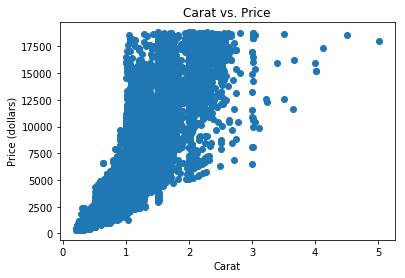

In [5]:
# bivariate plot of price vs. carat
plt.scatter(data = diamonds, x = 'carat', y = 'price')
plt.xlabel('Carat')
plt.ylabel('Price (dollars)')
plt.title('Carat vs. Price');

**Price vs. Carat comment 1:** <span style="color=white">Since these are both numeric variables, a scatterplot is a natural choice. We might also consider a heat map for this task. In either case, recall that the price distribution suggests a logarithmic transformation due to its very long tail, so we need to add a transformation to the price axis.</span>

In [6]:
diamonds[['price', 'carat']].describe()

,price,carat
count,53940.000000,53940.000000
mean,3932.799722,0.797940
std,3989.439738,0.474011
min,326.000000,0.200000
25%,950.000000,0.400000
50%,2401.000000,0.700000
75%,5324.250000,1.040000
max,18823.000000,5.010000


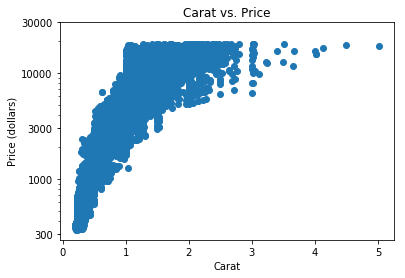

In [7]:
plt.scatter(data = diamonds, x = 'carat', y = 'price')
plt.xlabel('Carat')
plt.ylabel('Price (dollars)')
plt.title('Carat vs. Price')

plt.yscale('log')
tick_locs = [300, 1000, 3000, 10000, 30000]
plt.yticks(tick_locs, tick_locs);

**Price vs. Carat comment 2:** <span style="color=white"> When we put `price` on the y-axis and `carat` on the x-axis, the transformation should have changed the scatterplot from looking concave upwards (like an upwards-pointing bowl) to concave downards (like a downwards-pointing bowl). It would be nice to have a linear trend, wouldn't it? It turns out that the `x`, `y`, and `z` dimensions track a much more linear trend against price than `carat` does. 
    
Since `carat` is more recognizable a feature value, let's add a transformation to the x-axis to see the approximately linear trend. Since `carat` weight is proportional to volume, and since all the diamonds are cut in approximately the same way (round-cut), a **cube-root** transformation of carat should allow us to see an approximately linear trend.</span>

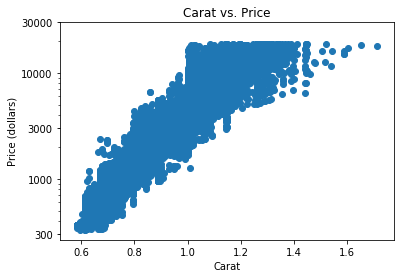

In [8]:
def cube_root(x):
    "Transformation x to a cube root of x"
    return np.cbrt(x)

plt.scatter(x = diamonds['carat'].apply(cube_root), y = diamonds['price'])

plt.xlabel('Carat')
plt.ylabel('Price (dollars)')
plt.title('Carat vs. Price')

plt.yscale('log')
tick_locs = [300, 1000, 3000, 10000, 30000]
plt.yticks(tick_locs, tick_locs);

**Price vs. Carat comment 3:** <span style="color=white">In the visualization after transformation, the trend between `price` and `carat` weight is 'cut off' by the maximum price limit of diamonds available in the dataset. For diamonds above about 1.5 carats, we'd expect some diamonds about $20,000 in `price`, given the trend below 1.5 carats. We should pay attention to later on with interaction effects between other factors, and when building a model of diamond prices.</span>

### 2. `Price` vs. one of three categorical quality features: `cut`, `color`, and `clarity`
Are there any surprising trends to be seen here?

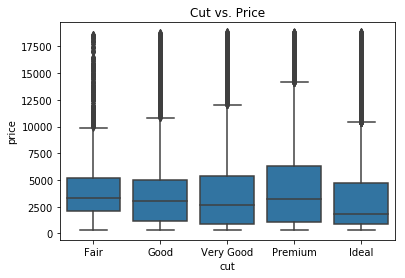

In [9]:
# bivariate plots of price vs. cut, color, clarity
sb.boxplot(data = diamonds, x = 'cut', y = 'price', color = sb.color_palette()[0])
plt.title('Cut vs. Price');

**Price vs. Categorical comment 1:** <span style="color=white">In the box plot above, the median `price` of diamonds tend to _decrease_ with _increasing_ quality. Shouldn't we expect this to be the other way around? This deserves a deeper look. Is there a different plot type to choose that shows more details in the data?</span>

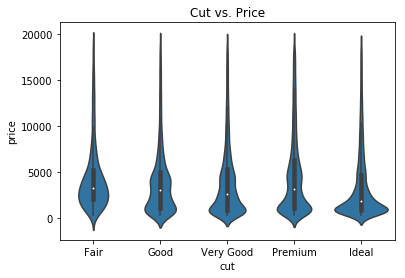

In [10]:
sb.violinplot(data = diamonds, x = 'cut', y = 'price', color = sb.color_palette()[0])
plt.title('Cut vs. Price');

**Price vs. Categorical comment 2:** <span style="color=white">With a violin plot, we can get more insight into what causes the trend in median prices to appear as it does. Faceted histograms will also produce a similar result, though unless the faceting keeps the `price` axis common across facets, the trend will be harder to see. 
    
For each ordinal variable, there are multiple modes into which prices appear to fall. Going across increasing quality levels, we can see that the modes rise in price - this should be the expected effect of quality. However, more of the data will be located in the lower-priced modes - this explains the unintuitive result noted in the previous comment. This is clearest in the clarity variable. Let's keep searching the data to see if there's more we can say about this pattern.</span>

### 3. Relationship between `carat` vs. `cut`, `color`, `clarity`

Before we complete the bivariate exploration, we should take a look at some of the relationships between the independent variables. Namely, how does `carat` weight change across the other three 'C' quality measures? You can take the same approach as the above investigation of price against the three categorical quality measures. What can you see in these plots, and how does this relate to your earlier investigations?

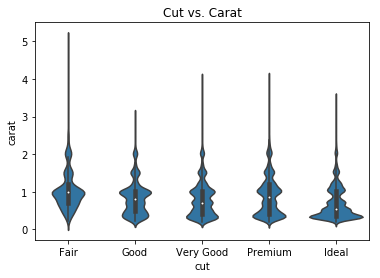

In [11]:
# bivariate plots of carat vs. cut
sb.violinplot(data = diamonds, x = 'cut', y = 'carat', color = sb.color_palette()[0])
plt.title('Cut vs. Carat');

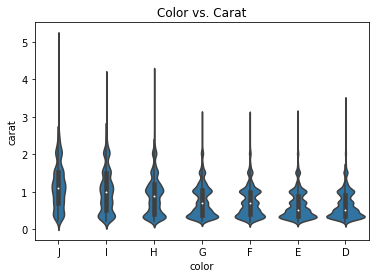

In [12]:
# bivariate plots of carat vs. color
sb.violinplot(data = diamonds, x = 'color', y = 'carat', color = sb.color_palette()[0])
plt.title('Color vs. Carat');

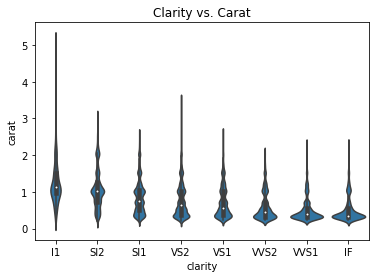

In [13]:
# bivariate plots of carat vs. clarity
sb.violinplot(data = diamonds, x = 'clarity', y = 'carat', color = sb.color_palette()[0])
plt.title('Clarity vs. Carat');

**Carat vs. Categorical comment:** <span style="color=white">These plots should shed a lot more light into the patterns already seen. Larger diamonds are more likely to receive lower categorical quality grades, while high quality grades are more likely to have their numbers made up of smaller diamonds. Since carat weight appears to be a major driver of price, this helps to explain the surprising marginal effect of diamond quality against price. The challenge next will be on how to depict this in a multivariate plot.</span>